# Sentinel Hub services  from within Python

In this example notebook we show how to use the processing API provided by [Sentinel Hub](https://www.sentinel-hub.com/) to download satellite imagery. We describe how to use various parameters and configurations to obtain either processed products or raw band data.

### Prerequisites

#### Sentinel Hub account

In order to use Sentinel Hub services you will need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

#### Credentials

In the [Sentinel Hub dashboard](https://apps.sentinel-hub.com/dashboard/) under "User settings" there is the "OAuth clients" where we create a new OAuth client and use its CLIENT_ID and CLIENT_SECRET to create an instance of `sentinelhub.SHConfig`. We provide the INSTANCE_ID we already have.

If we don't provide any credentials, sentinelhub-py will try to read our credentials from the system.

In [1]:
from sentinelhub import SHConfig

# In case you put the credentials into the configuration file you can leave this unchanged

CLIENT_ID = '' 
CLIENT_SECRET = ''

In [2]:
config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")
    

#### Imports 

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import datetime
import numpy as np
import os
import matplotlib.pyplot as plt

Note: `matplotlib` is not a dependency of `sentinelhub`.

In [5]:
from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, DataSource, bbox_to_dimensions

In [6]:
def plot_image(image, factor=1.0):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    
    plt.imshow(np.clip(image * factor, 0, 1))

#### Setting area of interest

We will download Sentinel-2 imagery of [Betsiboka Estuary](https://en.wikipedia.org/wiki/Betsiboka_River) such as the one shown below (taken by Sentinel-2 on 2017-12-15):
![title](data/wms_TRUE_COLOR_EPSG4326_-16.15_46.16_-15.58_46.51_2017-12-15T07-12-03_512X856.png)

The bounding box in _WGS84_ coordinate system is (longitude and latitude coordinates of upper left and lower right corners):

In [7]:
betsiboka_coords_wgs84 = [46.16, -16.15, 46.51, -15.58]

All requests require bounding box to be given as an instance of `sentinelhub.geometry.BBox` with corresponding Coordinate Reference System (`sentinelhub.geometry.CRS`). In our case it is in _WGS84_ and we can use the predefined _WGS84_ coordinate reference system from `sentinelhub.geometry.CRS`.

# TODO EXPLAIN THE SIZE

In [8]:
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=100)

## Example 1: True color (PNG) on a specific date

We build the request according to the [API Reference](https://docs.sentinel-hub.com/api/latest/reference/), using the `SentinelHubRequest` class. Each Processing API request also needs an [evalscript](https://docs.sentinel-hub.com/api/latest/#/Evalscript/V3/README).


The information that we specify in the SentinelHubRequest object is: 
 * the evalscript  
 * A list of input data sources with time interval. 
 * The format of the response 
 * Bounding box and it's size 

The evalscript is used to select the appropriate bands and scale the data so it is easy to visualize.

In [9]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource.SENTINEL2_L1C,
            time_interval=('2020-06-12T00:00:00', '2020-06-13T00:00:00'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

In [10]:
true_color_imgs = request_true_color.get_data()

Method `get_data()` will always return a list of available images from the requested time interval in form of numpy arrays. 

In [11]:
print('Returned data is of type = %s and length %d.' % (type(true_color_imgs), len(true_color_imgs)))
print('Single element in the list is of type {} and has shape {}'.format(type(true_color_imgs[-1]),
                                                                         true_color_imgs[-1].shape))

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (628, 379, 3)


In [12]:
true_color_imgs[0].dtype

dtype('uint8')

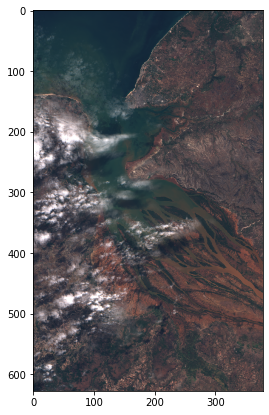

In [13]:
plot_image(true_color_imgs[0], factor=1/255)

###  Getting cloud mask

It is also possible to obtain cloud masks when requesting Sentinel-2 data.   

In [14]:
evalscript_clm = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04", 'CLM']
            }],
            output: {
                bands: 4
            }
        };
    }

    function evaluatePixel(sample) {
        return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02, sample.CLM];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_clm,
    input_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource.SENTINEL2_L1C,
            time_interval=('2020-06-12T00:00:00', '2020-06-13T00:00:00'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

In [15]:
data_with_cloud_mask = request_true_color.get_data()

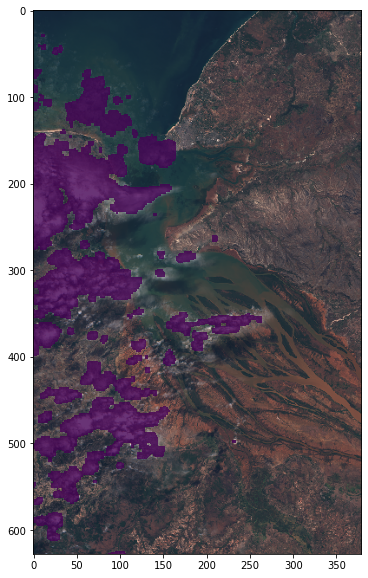

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(data_with_cloud_mask[0][..., [0, 1, 2]]*1/255)
clm = data_with_cloud_mask[0][... , 3].astype(np.float32)
clm[clm == 0] = np.nan

ax.imshow(clm, alpha=.8)

## Example 2: True color mosaic of least cloudy acquisitions  

### !!! todo opis daljšega time range intervala, pa zakaj je mosaicking order pomemben !!!

In [17]:
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource.SENTINEL2_L1C,
            time_interval=('2020-06-01T00:00:00', '2020-06-15T00:00:00'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
    )

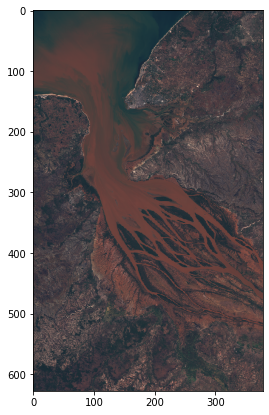

In [18]:
plot_image(request_true_color.get_data()[0], factor=1/255)

## Example 3: All Sentinel-2's raw band values 

Now let's define an evalscript which will return all Sentinel-2 spectral bands with raw values.

We have to set the `image_format` argument to `sentinelhub.constants.MimeType.TIFF`, since we can't pack all Sentinel-2's 13 bands into a png image.

In [19]:
evalscript_all_bands = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12"],
                units: "DN"

            }],
            output: {
                bands: 13,
                sampleType: "INT16"

            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01, 
                sample.B02, 
                sample.B03, 
                sample.B04, 
                sample.B05, 
                sample.B06, 
                sample.B07, 
                sample.B08, 
                sample.B8A, 
                sample.B09, 
                sample.B10, 
                sample.B11, 
                sample.B12];
    }
"""

request_all_bands = SentinelHubRequest(
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource.SENTINEL2_L1C,
            time_interval=('2020-06-01T00:00:00', '2020-06-15T00:00:00'),
            mosaicking_order='leastCC'
    )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
    )

In [20]:
all_bands_response = request_all_bands.get_data()

In [21]:
all_bands_response[-1][:, :, 12].shape

(628, 379)

Image showing SWIR band B12

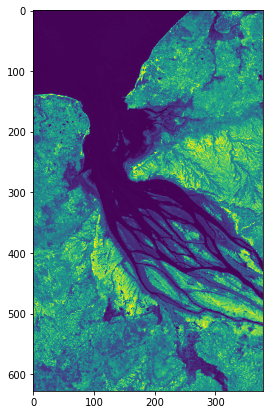

In [22]:
plot_image(all_bands_response[-1][:, :, 12], factor=3.5/10000)

From raw bands we can also construct a true color image

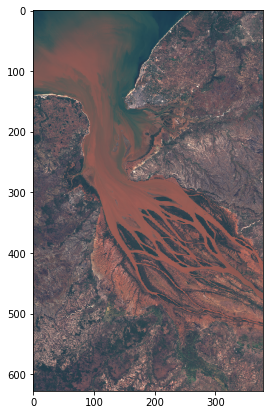

In [23]:
plot_image(all_bands_response[-1][:, :, [3, 2, 1]], factor=3.5/10000)

## Example 6: Save downloaded data to disk and read it from disk

All downloaded data can be saved to disk and later read from it. Simply specify the location on disk where data should be saved (or loaded from) via `data_folder` argument of request's constructor and set the argument `save_data` of `get_data` method to `True`.

In [24]:
request_all_bands = SentinelHubRequest(
    data_folder='test_dir',
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource.SENTINEL2_L1C,
            time_interval=('2020-06-01T00:00:00', '2020-06-15T00:00:00'),
            mosaicking_order='leastCC'
    )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
    )

In [25]:
%%time
all_bands_img = request_all_bands.get_data(save_data=True)

CPU times: user 54.1 ms, sys: 4.3 ms, total: 58.4 ms
Wall time: 30.1 ms


The output directory has been created and a tiff file with all 13 bands was saved into the following structure:

In [26]:
import os

for folder, _, filenames in os.walk(request_all_bands.data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))

test_dir/77b75aea0ebcf644b50a47bcca41453e/request.json
test_dir/77b75aea0ebcf644b50a47bcca41453e/response.tiff


Since data has been already downloaded the next request will read the data from disk instead of downloading it. That will be much faster.

In [27]:
%%time
all_bands_img_from_disk = request_all_bands.get_data()

CPU times: user 48 ms, sys: 3.87 ms, total: 51.9 ms
Wall time: 26.6 ms


In [28]:
if np.array_equal(all_bands_img[-1], all_bands_img_from_disk[-1]):
    print('Arrays are equal.')
else:
    print('Arrays are different.')

Arrays are equal.


If you need to redownload the data again, just set the `redownload` argument of `get_data()` method to `True`. 

In [29]:
%%time
all_bands_img_redownload = request_all_bands.get_data(redownload=True)

CPU times: user 194 ms, sys: 27.6 ms, total: 222 ms
Wall time: 2.65 s


## Example 7: Save downloaded data directly to disk

The `get_data` method returns a list of numpy arrays and can save the downloaded data to disk, as we have seen in the previous example. Sometimes you would just like to save the data directly to disk for later use. You can do that by using `save_data` method instead.

In [30]:
%%time
request_all_bands.save_data()

CPU times: user 631 µs, sys: 134 µs, total: 765 µs
Wall time: 547 µs


The output directory has been created and tiff file for the image should be in it.

In [31]:
for top, dirs, files in os.walk(request_all_bands.data_folder):
    for nm in files:       
        print(os.path.join(top, nm))

test_dir/77b75aea0ebcf644b50a47bcca41453e/request.json
test_dir/77b75aea0ebcf644b50a47bcca41453e/response.tiff


# TODO Multiple requests
### Is this even here? 

### Data Sources

The package supports various data sources. Currently the following is supported:

In [33]:
from sentinelhub import DataSource

for source in DataSource.get_available_sources():
    print(source)

DataSource.SENTINEL2_L1C
DataSource.SENTINEL2_L2A
DataSource.SENTINEL1_IW
DataSource.SENTINEL1_EW
DataSource.SENTINEL1_EW_SH
DataSource.SENTINEL1_IW_ASC
DataSource.SENTINEL1_EW_ASC
DataSource.SENTINEL1_EW_SH_ASC
DataSource.SENTINEL1_IW_DES
DataSource.SENTINEL1_EW_DES
DataSource.SENTINEL1_EW_SH_DES
DataSource.DEM
DataSource.MODIS
DataSource.LANDSAT8
DataSource.SENTINEL5P


Examples to obtain DEM and custom BYOC data are provided below.

## DEM

### TODO: add text

In [34]:
evalscript_dem = '''
//VERSION=3
function setup() {
  return {
    input: ["DEM"],
    output: { bands: 1 }
  }
}

function evaluatePixel(sample) {
  return [sample.DEM/1000]
}
'''

In [35]:
dem_request = SentinelHubRequest(
    evalscript=evalscript_dem,
    input_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource.DEM,
            time_interval=('2018-12-30', '2019-01-01'),
    )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
    )

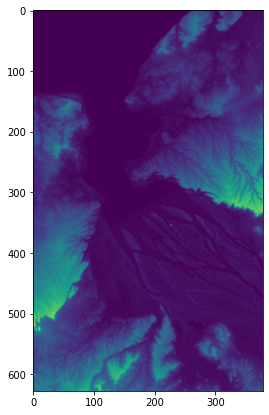

In [36]:
dem_data = dem_request.get_data()
plot_image(dem_data[0], factor=1/255)

## Example : Custom (BYOC) data

It is possible that you "bring your own data" (BYOC) and access it using Sentinel Hub in a similar manner as any other satellite data. 
To be able to access your own data using Sentinel Hub you will need to prepare a few things. Roughly speaking these are (find all details here: https://docs.sentinel-hub.com/api/latest/#/API/byoc):
- Convert your data to Cloud Optimized GeoTiff (COG) format. Store it in AWS S3 bucket and allow SH to access it.
- Create collection in SH, which points to the S3 bucket. Within the collection, create tiles. 
- Create new layer in your configuration, which points to the collection.
- Request the data using SentinelHub.py package

To demonstrate this, we have prepeared a demo S3 bucket, demo collection and demo layer in our configuration. To access this data we need collection id = '31df1de4-8bd4-43e0-8c3f-b04262d111b6' and layer id = 'DEMO_BYOC_LAYER'. Let see how to request the custom data.

In [65]:
byoc_bbox = BBox([35.138397,36.837866,35.824356,37.139519], crs=CRS.WGS84)
byoc_size = bbox_to_dimensions(byoc_bbox, resolution=100)
collection_id = '7453e962-0ee5-4f74-8227-89759fbe9ba9'

In [66]:
evalscript_byoc = '''
//VERSION=3
function setup() {
  return {
    input: [{
      bands: ["lulc_reference", "dataMask"],
    }],
    mosaicking: "TILE",
    output: { id: "default", bands: 3}
  };
}

function colorPixel(value) {
  if(value == 1){ return [255/255, 255/255, 0/255];}
  if(value == 2){ return [5/255, 73/255, 7/255];}
  if(value == 3){ return [255/255, 165/255, 0/255];}
  if(value == 4){ return [128/255, 96/255, 0/255];}
  if(value == 5){ return [6/255, 154/255, 243/255];}
  if(value == 6){ return [149/255, 208/255, 252/255];}
  if(value == 7){ return [80/255, 33/255, 213/255];}
  if(value == 8){ return [220/255, 20/255, 60/255];}
  if(value == 9){ return [166/255, 166/255, 166/255];}
  if(value == 10){ return [0/255, 0/255, 0/255];}
  if(value == 11){ return [70/255, 52/255, 0/255];}
}

function evaluatePixel(samples, scenes) {
  for (let i = 0; i < samples.length; i++) {
    let sample = samples[i];
    if (sample.dataMask == 1 && sample.lulc_reference != 0) {
      return colorPixel(sample.lulc_reference);
    }
  }
  return [1, 1, 1];
}
'''

In [69]:
byoc_request = SentinelHubRequest(
    evalscript=evalscript_byoc,
    input_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource(collection_id),
            time_interval=('2018-12-30', '2019-01-01'),
            mosaicking_order='leastCC'
    )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=byoc_bbox,
    size=byoc_size,
    config=config
    )

In [70]:
byoc_data = byoc_request.get_data()
plt.imshow(byoc_data[0])

DownloadFailedException: Failed to download from:
https://services.sentinel-hub.com/api/v1/process
with HTTPError:
500 Server Error: Internal Server Error for url: https://services.sentinel-hub.com/api/v1/process
Server response: "{"error":{"status":500,"reason":"Internal Server Error","message":"java.util.concurrent.ExecutionException: java.util.concurrent.ExecutionException: java.lang.RuntimeException: Index service failure: 500 Internal Server Error","code":"RENDERER_EXCEPTION"}}"